## Using Search Algorithms

In [1]:
from overrides import overrides
import torch
from torch import nn
import numpy as np
import json
from typing import Tuple
from random import Random

from typing import Tuple, List, Optional
from archai.discrete_search import ArchaiModel, EvolutionarySearchSpace, BayesOptSearchSpace

**Let's use the search space from the first notebook**

In [2]:
class MyModel(nn.Module):
    def __init__(self, nb_layers: int = 5, kernel_size: int = 3, hidden_dim: int = 32):
        super().__init__()
        
        self.nb_layers = nb_layers
        self.kernel_size = kernel_size
        self.hidden_dim = hidden_dim
        
        layer_list = []

        for i in range(nb_layers):
            in_ch = (1 if i == 0 else hidden_dim)
            
            layer_list += [
                nn.Conv2d(in_ch, hidden_dim, kernel_size=kernel_size, padding=(kernel_size-1)//2),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(),
            ]
            
        layer_list += [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Conv2d(hidden_dim, 10, kernel_size=1)
        ]

        self.model = nn.Sequential(*layer_list)
    
    def forward(self, x):
        return self.model(x).squeeze()
    
    def get_archid(self):
        return f'({self.nb_layers}, {self.kernel_size}, {self.hidden_dim})'

In [3]:
class CNNSearchSpace(EvolutionarySearchSpace, BayesOptSearchSpace):
    def __init__(self, min_layers: int = 1, max_layers: int = 12,
                 kernel_list=(1, 3, 5, 7), hidden_list=(16, 32, 64, 128),
                 seed: int = 1):

        self.min_layers = min_layers
        self.max_layers = max_layers
        self.kernel_list = kernel_list
        self.hidden_list = hidden_list
        
        self.rng = Random(seed)
        
    @overrides
    def random_sample(self) -> ArchaiModel:
        # Randomly chooses architecture parameters
        nb_layers = self.rng.randint(self.min_layers, self.max_layers)
        kernel_size = self.rng.choice(self.kernel_list)
        hidden_dim = self.rng.choice(self.hidden_list)
        
        model = MyModel(nb_layers, kernel_size, hidden_dim)
        
        # Wraps model into ArchaiModel
        return ArchaiModel(arch=model, archid=model.get_archid())

    @overrides
    def save_arch(self, model: ArchaiModel, file: str):
        with open(file, 'w') as fp:
            json.dump({
                'nb_layers': model.arch.nb_layers,
                'kernel_size': model.arch.kernel_size,
                'hidden_dim': model.arch.hidden_dim
            }, fp)

    @overrides
    def load_arch(self, file: str):
        config = json.load(open(file))
        model = MyModel(**config)
        
        return ArchaiModel(arch=model, archid=model.get_archid())

    @overrides
    def save_model_weights(self, model: ArchaiModel, file: str):
        state_dict = model.arch.get_state_dict()
        torch.save(state_dict, file)
    
    @overrides
    def load_model_weights(self, model: ArchaiModel, file: str):
        model.arch.load_state_dict(torch.load(file))

    @overrides
    def mutate(self, model_1: ArchaiModel) -> ArchaiModel:
        config = {
            'nb_layers': model_1.arch.nb_layers,
            'kernel_size': model_1.arch.kernel_size,
            'hidden_dim': model_1.arch.hidden_dim
        }
        
        if self.rng.random() < 0.2:
            config['nb_layers'] = self.rng.randint(self.min_layers, self.max_layers)
        
        if self.rng.random() < 0.2:
            config['kernel_size'] = self.rng.choice(self.kernel_list)
        
        if self.rng.random() < 0.2:
            config['hidden_dim'] = self.rng.choice(self.hidden_list)
        
        mutated_model = MyModel(**config)
        
        return ArchaiModel(
            arch=mutated_model, archid=mutated_model.get_archid()
        )
    
    @overrides
    def crossover(self, model_list: List[ArchaiModel]) -> ArchaiModel:
        model_1, model_2 = model_list[:2]
        
        new_config = {
            'nb_layers': self.rng.choice([model_1.arch.nb_layers, model_2.arch.nb_layers]),
            'kernel_size': self.rng.choice([model_1.arch.kernel_size, model_2.arch.kernel_size]),
            'hidden_dim': self.rng.choice([model_1.arch.hidden_dim, model_2.arch.hidden_dim]),
        }
        
        crossover_model = MyModel(**new_config)
        
        return ArchaiModel(
            arch=crossover_model, archid=crossover_model.get_archid()
        )
    
    @overrides
    def encode(self, model: ArchaiModel) -> np.ndarray:
        return np.array([model.arch.nb_layers, model.arch.kernel_size, model.arch.hidden_dim])

In [4]:
ss = CNNSearchSpace(max_layers=10, kernel_list=[3, 5, 7], hidden_list=[32, 64, 128])

In [5]:
m = ss.random_sample()
m

ArchaiModel(
	archid=(3, 7, 32), 
	metadata={}, 
	arch=MyModel(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): AdaptiveAvgPool2d(output_size=(1, 1))
    (10): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
  )
)
)

### **Dataset**

In [7]:
from pathlib import Path
from archai.datasets.providers.mnist_provider import MnistProvider

In [8]:
dataset_provider = MnistProvider({'dataroot': Path.home() / 'dataroot'})

### Search objectives

Let's use Partial trainig validation accuracy as a proxy for task performance

In [9]:
from archai.discrete_search import Objective
from archai.discrete_search.objectives.onnx_model import AvgOnnxLatency
from archai.discrete_search.objectives.torch_model import TorchFlops, TorchNumParameters
from archai.discrete_search.objectives.ray import RayParallelObjective

In [10]:
from torchvision.transforms import Compose, ToTensor, Normalize
from tqdm import tqdm

In [11]:
class PartialTrainingValAccuracy(Objective):
    higher_is_better: bool = True

    def __init__(self, training_epochs: int = 2, lr: float = 1e-4, device: str = 'cuda'):
        self.training_epochs = training_epochs
        self.device = device
        self.lr = lr
        self.preprocess = ToTensor()
    
    @overrides
    def evaluate(self, model, dataset_provider, budget = None) -> float:
        # Loads the dataset
        tr_data, val_data = dataset_provider.get_datasets(True, True, self.preprocess, self.preprocess)
        tr_dl = torch.utils.data.DataLoader(tr_data, batch_size=16, shuffle=True, num_workers=4)
        val_dl = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False, num_workers=4)
        
        # Training settings
        optimizer = torch.optim.Adam(model.arch.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        
        model.arch.train()
        model.arch.to(self.device)
        
        # Partial training
        for epoch_nb in tqdm(range(self.training_epochs), desc=f'Training model {model.archid}'):
            for i, (x, y) in enumerate(tr_dl):
                optimizer.zero_grad()
                
                pred = model.arch(x.to(self.device))
                loss = criterion(pred, y.to(self.device))

                loss.backward()
                optimizer.step()
        
        # Evaluates final model
        model.arch.eval()
        
        with torch.no_grad():
            val_pred, val_target = [], []

            for x, y in val_dl:
                val_pred.append(model.arch(x.to(self.device)).argmax(axis=1).to('cpu'))
                val_target.append(y.to('cpu'))

            val_pred, val_target = torch.cat(val_pred, axis=0), torch.cat(val_target, axis=0)
            val_acc = (val_pred.squeeze() == val_target.squeeze()).numpy().mean()

        # Returns model to cpu
        model.arch.cpu()
        

        return val_acc

Search objectives can be defined as a dictionary of Objectives

In [12]:
objectives = {
    'Onnx Latency (ms)': AvgOnnxLatency(input_shape=(1, 1, 28, 28), num_trials=3),
    'FLops': TorchFlops(input_shape=(1, 1, 28, 28)),
    
    # To speed evaluation, we'll train multiple models in parallel
    'Partial training Validation Accuracy': RayParallelObjective(
        PartialTrainingValAccuracy(training_epochs=1), num_gpus=0.5, # 2 jobs per gpu available
        max_calls=1
    )
}

In [249]:
objectives['Partial training Validation Accuracy'].send(ss.random_sample(), dataset_provider)
objectives['Partial training Validation Accuracy'].send(ss.random_sample(), dataset_provider)

Training model (2, 7, 128): 100%|██████████| 1/1 [00:42<00:00, 42.35s/it]


In [227]:
objectives['Partial training Validation Accuracy'].fetch_all()

Training model (8, 3, 128): 100%|██████████| 1/1 [00:46<00:00, 46.95s/it]


[0.9894, 0.9753]

### Choosing a search algorithm

Let's try `EvolutionParetoSearch` first

In [13]:
from archai.discrete_search.algos.evolution_pareto import EvolutionParetoSearch

In [15]:
algo = EvolutionParetoSearch(
    search_space=ss, objectives=objectives, dataset_provider=dataset_provider, 
    output_dir='/tmp/out_evo2', num_iters=5, num_crossovers=5, mutations_per_parent=2
)

19:36 Using 10 random architectures as the initial population
19:36 starting evolution pareto iter 0
19:36 iter 0: calculating search objectives {'Onnx Latency (ms)': <archai.discrete_search.objectives.onnx_model.AvgOnnxLatency object at 0x7f61b56a1610>, 'FLops': <archai.discrete_search.objectives.torch_model.TensorwatchStat object at 0x7f61c499e550>, 'Partial training Validation Accuracy': <archai.discrete_search.objectives.ray.RayParallelObjective object at 0x7f61c48ffca0>} for 10 models
Dispatching jobs for "Partial training Validation Accuracy"...:   0%| | 0/10 [02022-10-27 19:36:34,879	INFO worker.py:1518 -- Started a local Ray instance.
Dispatching jobs for "Partial training Validation Accuracy"...: 100%|█| 10/10 [
Training model (1, 5, 128): 100%|██████████| 1/1 [00:17<00:00, 17.02s/it]
Gathering results from async objectives...: 100%|█| 1/1 [01:06<00:00, 66.31s/it
19:37 iter 0: updating the pareto
19:37 iter 0: found 9 members
19:37 iter 0: chose 9 parents
19:37 iter 0: number 

Training model (10, 3, 32): 100%|██████████| 1/1 [00:53<00:00, 53.78s/it]
Gathering results from async objectives...: 100%|█| 1/1 [03:11<00:00, 191.23s/i
19:43 iter 2: updating the pareto
19:43 iter 2: found 23 members
19:43 iter 2: chose 23 parents
19:43 iter 2: number of parents after objective fn. filter = 23
Mutating parents: 100%|████████████████████████| 23/23 [00:01<00:00, 22.50it/s]
19:43 iter 2: mutation yielded 18 new models
19:43 iter 2: crossover yielded 0 new models
19:43 iter 2: total unseen population before restriction 23
19:43 iter 2: total unseen population after restriction 23
19:43 starting evolution pareto iter 3
19:43 iter 3: calculating search objectives {'Onnx Latency (ms)': <archai.discrete_search.objectives.onnx_model.AvgOnnxLatency object at 0x7f61b56a1610>, 'FLops': <archai.discrete_search.objectives.torch_model.TensorwatchStat object at 0x7f61c499e550>, 'Partial training Validation Accuracy': <archai.discrete_search.objectives.ray.RayParallelObjective objec

Gathering results from async objectives...: 100%|█| 1/1 [02:57<00:00, 177.95s/i
19:46 iter 3: updating the pareto
19:46 iter 3: found 28 members
19:46 iter 3: chose 28 parents
19:46 iter 3: number of parents after objective fn. filter = 28
Mutating parents: 100%|████████████████████████| 28/28 [00:01<00:00, 15.52it/s]
19:46 iter 3: mutation yielded 12 new models
19:46 iter 3: crossover yielded 0 new models
19:46 iter 3: total unseen population before restriction 17
19:46 iter 3: total unseen population after restriction 17
19:46 starting evolution pareto iter 4
19:46 iter 4: calculating search objectives {'Onnx Latency (ms)': <archai.discrete_search.objectives.onnx_model.AvgOnnxLatency object at 0x7f61b56a1610>, 'FLops': <archai.discrete_search.objectives.torch_model.TensorwatchStat object at 0x7f61c499e550>, 'Partial training Validation Accuracy': <archai.discrete_search.objectives.ray.RayParallelObjective object at 0x7f61c48ffca0>} for 17 models
Dispatching jobs for "Partial training

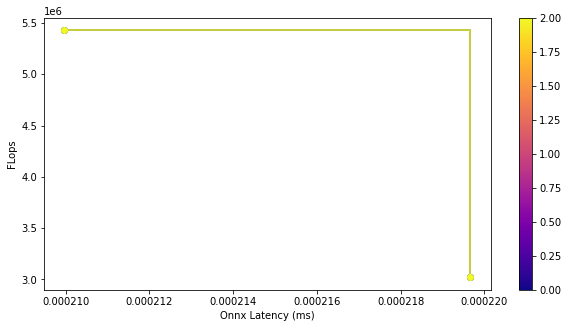

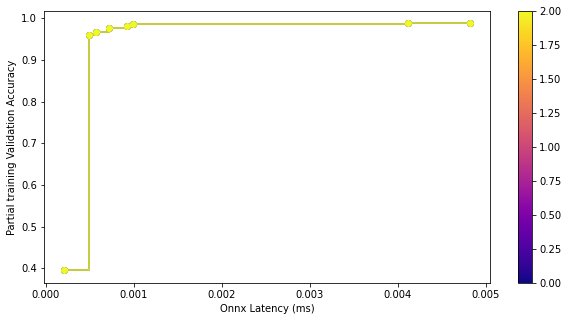

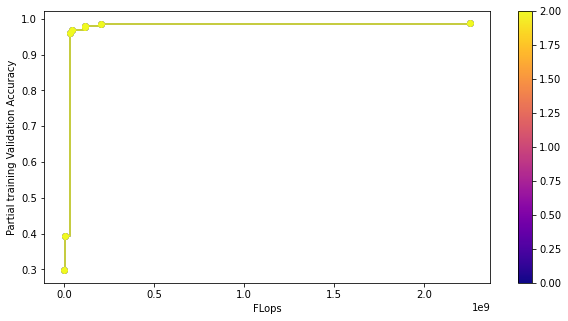

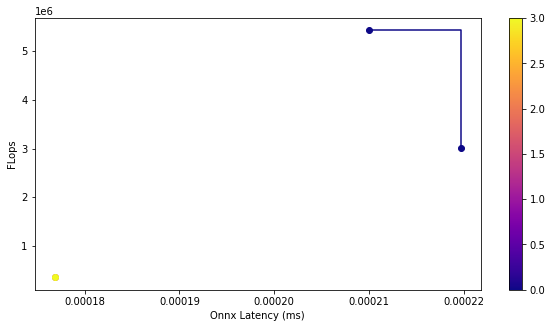

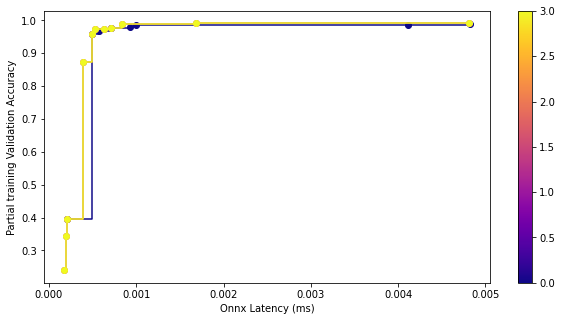

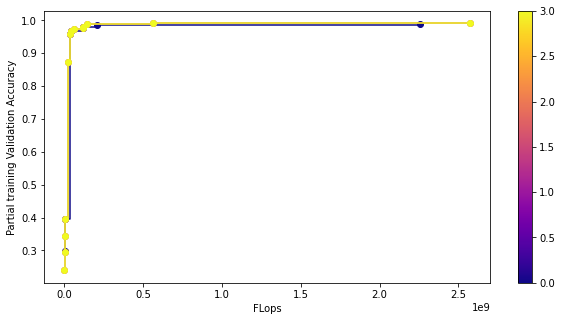

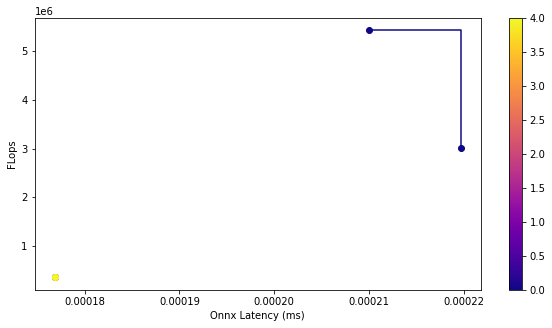

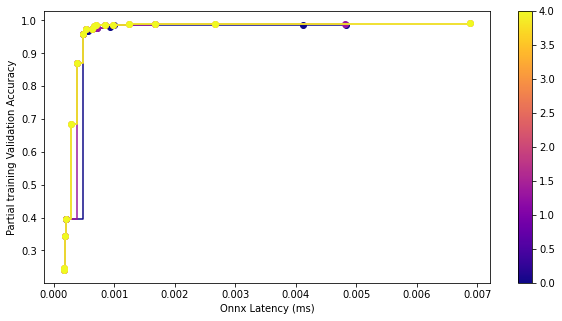

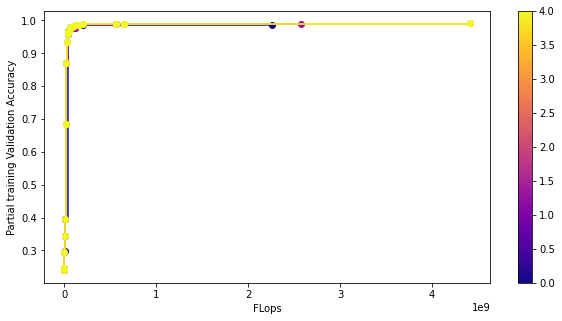

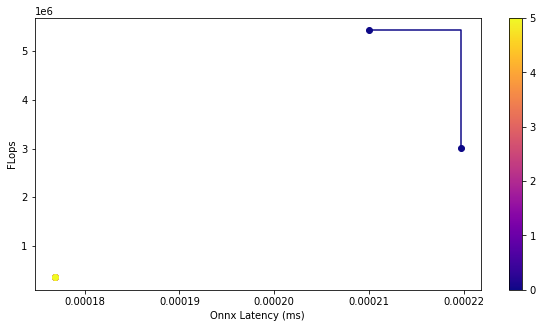

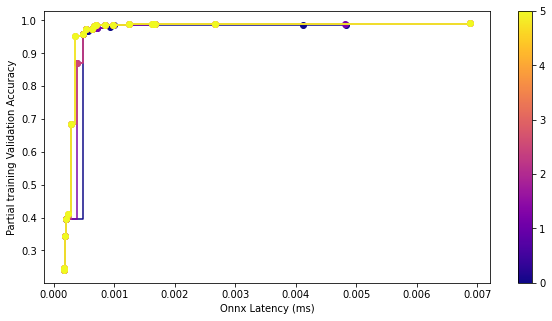

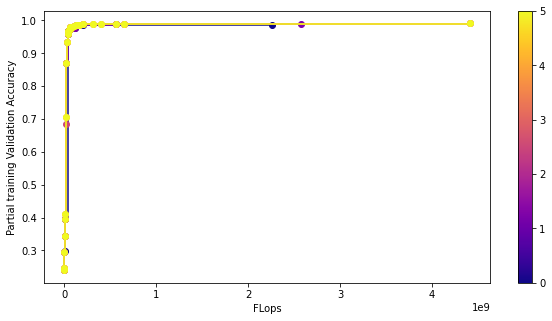

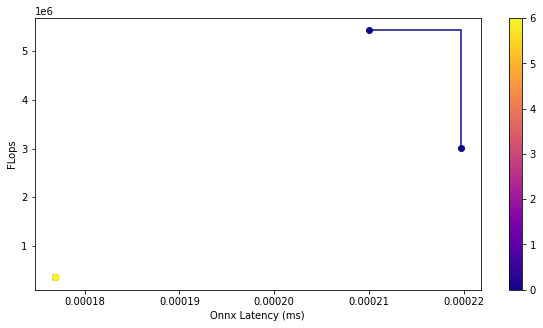

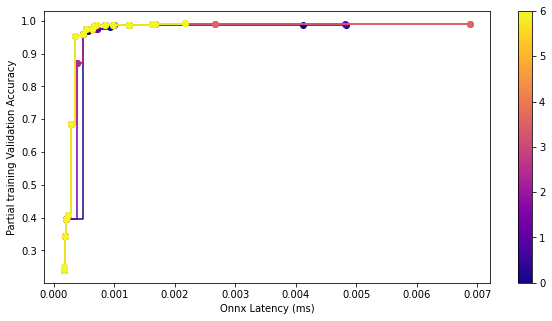

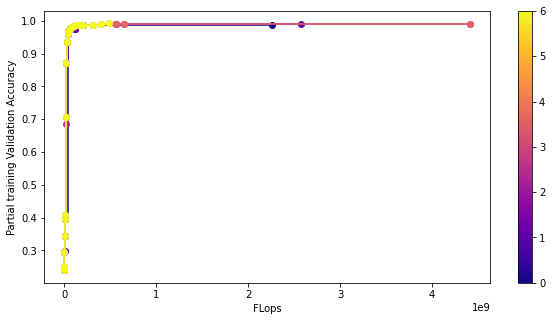

In [16]:
search_results = algo.search()

Outputs saved by the algorithm

In [19]:
!ls /tmp/out_evo2

log.log
pareto_FLops_vs_Partial_training_Validation_Accuracy.png
pareto_models_iter_1
pareto_models_iter_2
pareto_models_iter_3
pareto_models_iter_4
pareto_models_iter_5
pareto_Onnx_Latency_ms_vs_FLops.png
pareto_Onnx_Latency_ms_vs_Partial_training_Validation_Accuracy.png
search_state_1.csv
search_state_2.csv
search_state_3.csv
search_state_4.csv
search_state_5.csv


In [20]:
search_results.get_search_state_df().query('is_pareto').plot('Onnx Latency (ms)', 'Partial training Validation Accuracy')

,archid,models,Onnx Latency (ms),FLops,Partial training Validation Accuracy,parent,parents,iteration_num,Search walltime (hours),is_pareto
2,"(7, 3, 32)","ArchaiModel(\n\tarchid=(7, 3, 32), \n\tmetadat...",0.000574,44307562.0,0.9678,None,None,0,0.020200,True
7,"(6, 3, 32)","ArchaiModel(\n\tarchid=(6, 3, 32), \n\tmetadat...",0.000490,36981866.0,0.9597,None,None,0,0.020200,True
8,"(1, 7, 128)","ArchaiModel(\n\tarchid=(1, 7, 128), \n\tmetada...",0.000210,5427594.0,0.3948,None,None,0,0.020200,True
10,"(1, 7, 64)","ArchaiModel(\n\tarchid=(1, 7, 64), \n\tmetadat...",0.000192,2713802.0,0.3429,"(1, 7, 128)",None,1,0.064299,True
11,"(4, 3, 32)","ArchaiModel(\n\tarchid=(4, 3, 32), \n\tmetadat...",0.000390,22330474.0,0.8717,"(4, 7, 32)",None,1,0.064299,True
13,"(4, 5, 32)","ArchaiModel(\n\tarchid=(4, 5, 32), \n\tmetadat...",0.000527,61267050.0,0.9739,"(4, 7, 32)",None,1,0.064299,True
17,"(8, 5, 64)","ArchaiModel(\n\tarchid=(8, 5, 64), \n\tmetadat...",0.001682,564885706.0,0.9906,None,"(1, 5, 128),(8, 3, 64)",1,0.064299,True
19,"(9, 3, 32)","ArchaiModel(\n\tarchid=(9, 3, 32), \n\tmetadat...",0.000630,58958954.0,0.9746,"(6, 3, 32)",None,1,0.064299,True
25,"(8, 5, 32)","ArchaiModel(\n\tarchid=(8, 5, 32), \n\tmetadat...",0.000840,141950058.0,0.9874,None,"(6, 3, 32),(8, 5, 128)",1,0.064299,True
27,"(1, 7, 32)","ArchaiModel(\n\tarchid=(1, 7, 32), \n\tmetadat...",0.000204,1356906.0,0.2938,"(1, 7, 128)",None,1,0.064299,True


Since our search space is also compatible with Bayesian Optimization algorithms, let's a more sophisticated algorithm like MO-BANANAS

In [22]:
from archai.discrete_search.algos.bananas import MoBananasSearch

In [26]:
algo2 = MoBananasSearch(
    search_space=ss, objectives=objectives, dataset_provider=dataset_provider, 
    output_dir='/tmp/out_bananas', 
    cheap_objectives=['Onnx Latency (ms)', 'FLops'], # Cheap objectives won't be predicted by the surrogate model
    num_iters=5, mutations_per_parent=5, num_mutations=10
)

19:56 Starting iteration 0
19:56 Evaluating objectives for 10 architectures
Dispatching jobs for "Partial training Validation Accuracy"...: 100%|█| 10/10 [00:
Gathering results from async objectives...: 100%|███| 1/1 [01:05<00:00, 65.87s/it]
19:57 Updating surrogate model...
Training DNN Ensemble...: 100%|█████████████████████| 5/5 [00:25<00:00,  5.18s/it]
/home/pkauffmann/archai/archai/discrete_search/algos/utils/multi_objective.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frontiers = np.array(
19:57 Generating mutations for 10 parent architectures...
19:57 Predicting objectives ['Partial training Validation Accuracy'] using surrogate model
19:57 Calculating cheap objectives ['Onnx Latency (ms)', 'FLops']
Calculating "FLops"...: 100%|██████████████████| 118/1

20:01 Predicting objectives ['Partial training Validation Accuracy'] using surrogate model
20:01 Calculating cheap objectives ['Onnx Latency (ms)', 'FLops']
Calculating "FLops"...: 100%|████████████████████| 49/49 [00:00<00:00, 124.39it/s]
Gathering results from async objectives...: 0it [00:00, ?it/s]
20:01 4 candidate architectures were selected for the next iteration
20:01 Starting iteration 4
20:01 Evaluating objectives for 4 architectures
Dispatching jobs for "Partial training Validation Accuracy"...: 100%|█| 4/4 [00:00
Gathering results from async objectives...: 100%|███| 1/1 [00:47<00:00, 47.21s/it]
20:02 Updating surrogate model...
Training DNN Ensemble...: 100%|█████████████████████| 5/5 [00:25<00:00,  5.09s/it]
/home/pkauffmann/archai/archai/discrete_search/algos/utils/multi_objective.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you

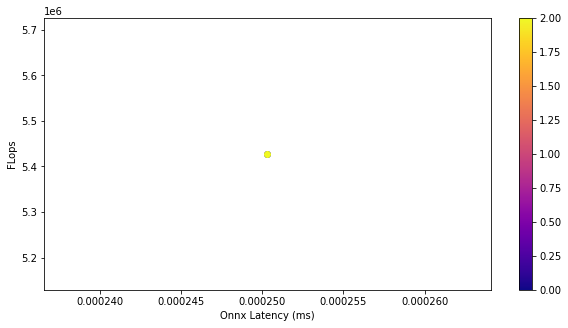

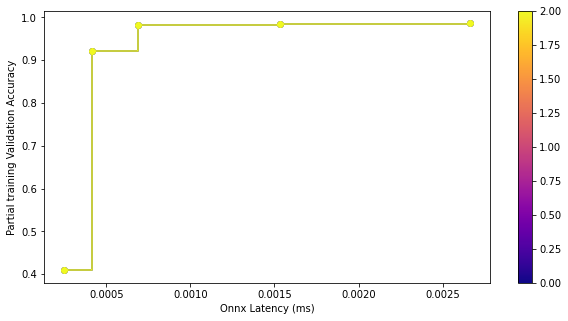

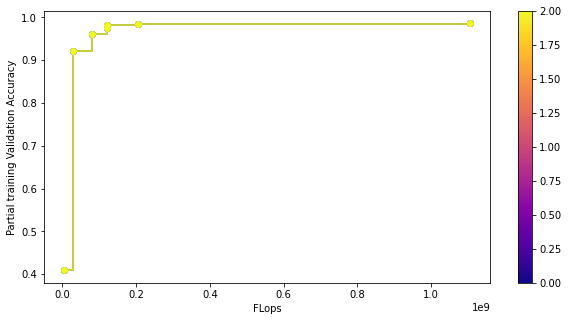

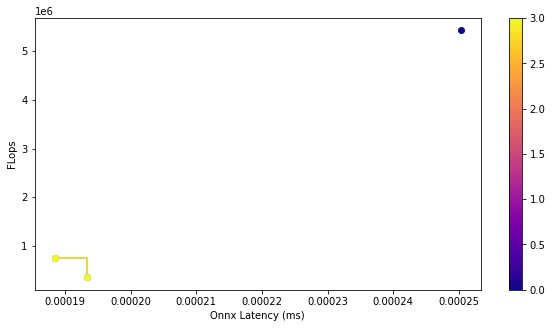

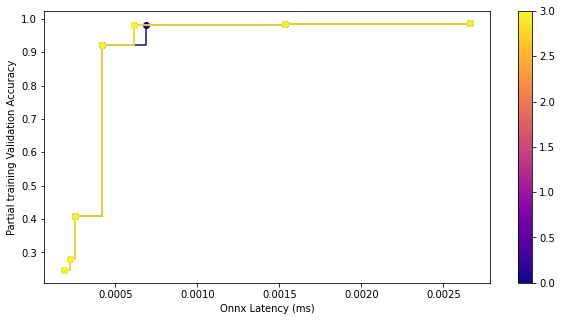

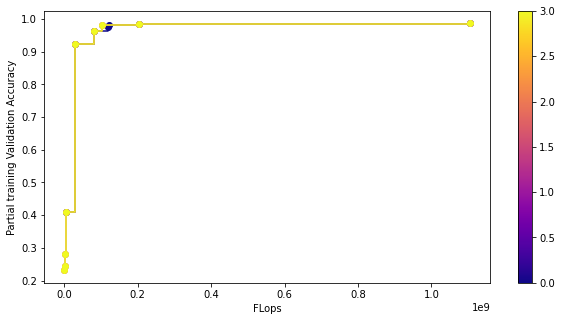

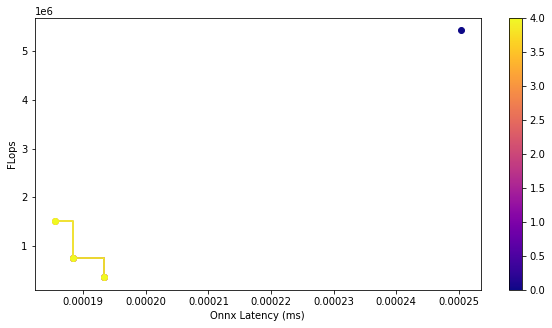

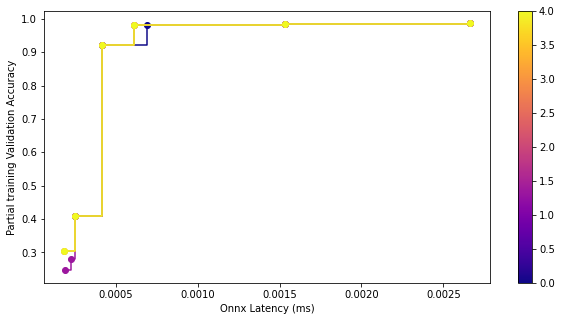

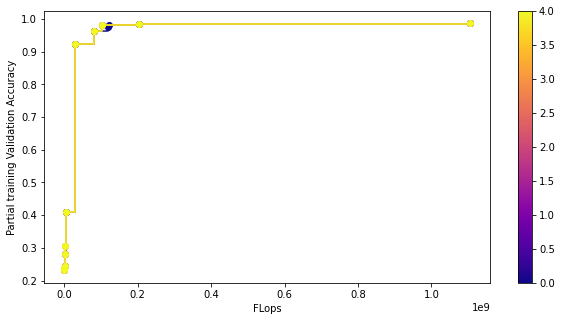

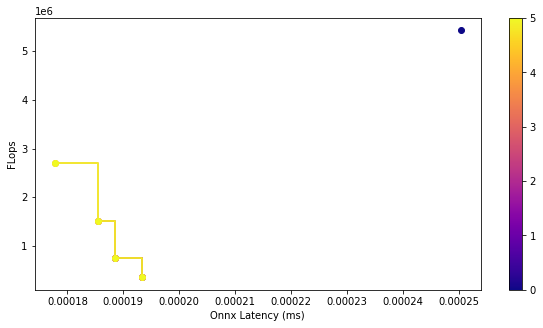

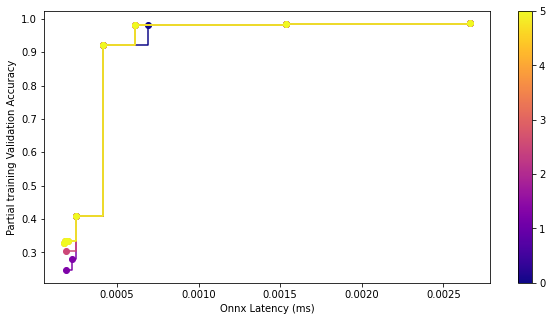

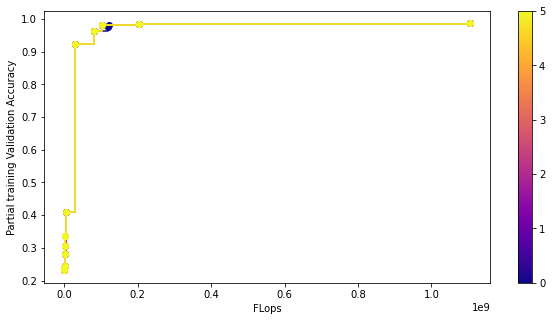

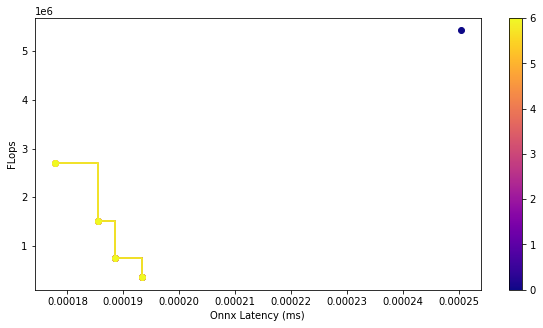

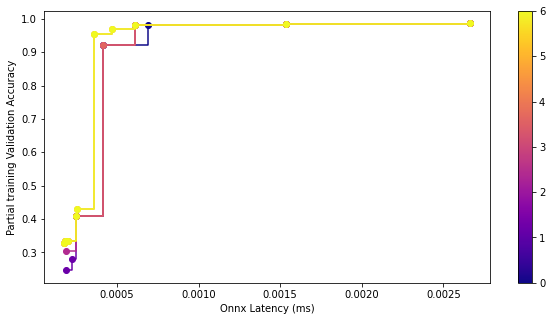

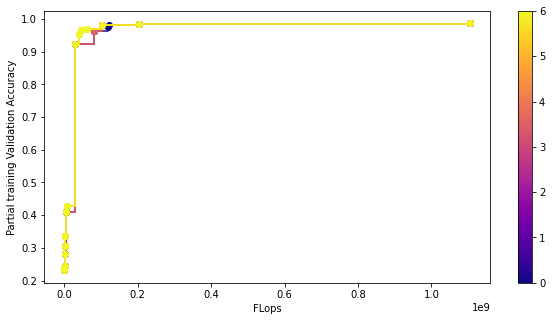

In [27]:
search_results2 = algo2.search()

In [33]:
!ls /tmp/out_bananas

log.log
pareto_FLops_vs_Partial_training_Validation_Accuracy.png
pareto_Onnx_Latency_ms_vs_FLops.png
pareto_Onnx_Latency_ms_vs_Partial_training_Validation_Accuracy.png
search_state_0.csv
search_state_1.csv
search_state_2.csv
search_state_3.csv
search_state_4.csv


In [32]:
search_results2.get_search_state_df().query('is_pareto')

,archid,models,Onnx Latency (ms),FLops,Partial training Validation Accuracy,iteration_num,Predicted Partial training Validation Accuracy mean,Predicted Partial training Validation Accuracy var,Search walltime (hours),is_pareto
0,"(1, 7, 128)","ArchaiModel(\n\tarchid=(1, 7, 128), \n\tmetada...",0.000250,5.427594e+06,0.4086,0,NaN,NaN,0.020570,True
4,"(8, 3, 64)","ArchaiModel(\n\tarchid=(8, 3, 64), \n\tmetadat...",0.001535,2.044213e+08,0.9855,0,NaN,NaN,0.020570,True
6,"(5, 3, 32)","ArchaiModel(\n\tarchid=(5, 3, 32), \n\tmetadat...",0.000417,2.965617e+07,0.9218,0,NaN,NaN,0.020570,True
7,"(8, 7, 64)","ArchaiModel(\n\tarchid=(8, 7, 64), \n\tmetadat...",0.002664,1.105582e+09,0.9863,0,NaN,NaN,0.020570,True
10,"(1, 7, 32)","ArchaiModel(\n\tarchid=(1, 7, 32), \n\tmetadat...",0.000223,1.356906e+06,0.2814,1,0.934935,0.000282,0.046087,True
11,"(1, 5, 32)","ArchaiModel(\n\tarchid=(1, 5, 32), \n\tmetadat...",0.000188,7.547940e+05,0.2460,1,0.901442,0.000335,0.046087,True
12,"(1, 3, 32)","ArchaiModel(\n\tarchid=(1, 3, 32), \n\tmetadat...",0.000193,3.533860e+05,0.2310,1,0.886158,0.000155,0.046087,True
13,"(6, 5, 32)","ArchaiModel(\n\tarchid=(6, 5, 32), \n\tmetadat...",0.000612,1.016086e+08,0.9817,1,0.968243,0.000004,0.046087,True
14,"(1, 3, 64)","ArchaiModel(\n\tarchid=(1, 3, 64), \n\tmetadat...",0.000201,7.067620e+05,0.2393,2,0.608295,0.002555,0.064302,True
15,"(1, 5, 64)","ArchaiModel(\n\tarchid=(1, 5, 64), \n\tmetadat...",0.000185,1.509578e+06,0.3046,2,0.615983,0.000562,0.064302,True
